# Similarity & Affine Transformations
*  Our current method is based on a similiarity transformation (translation, scale, rotation).
*  Only usable for floor plans with correct dimensions and aspect ratio and no scanning distortions.
*  Going from two reference points to three makes a difference. We can switch to a full affine transformation for a much better fit.
*  Adding additional reference points slowly improves the fit. Might make a difference when the floorplan is distorted.
*  With more than 3 reference points, a least squares affine matrix estimation method gives much better fit.

In [1]:
%matplotlib inline
from utils import polygon, plot, Point, RefPoint, scale, translate, rotate, polyline2array
from IPython.display import Image
import matplotlib.pyplot as plt
import math
from skimage import io, data
import numpy as np
from skimage.transform import warp, SimilarityTransform, estimate_transform, warp_coords
from scipy.ndimage import map_coordinates

We have the following floor plan in form of a raster image. This is the original version of the floor plan with one slight change. I corrected the distortion found in the original image in the bitmap editor Gimp to make sure that all "wall" lines are aligned horizonally and vertically (more or less).

Floorplan dimensions: width=1202 height=799


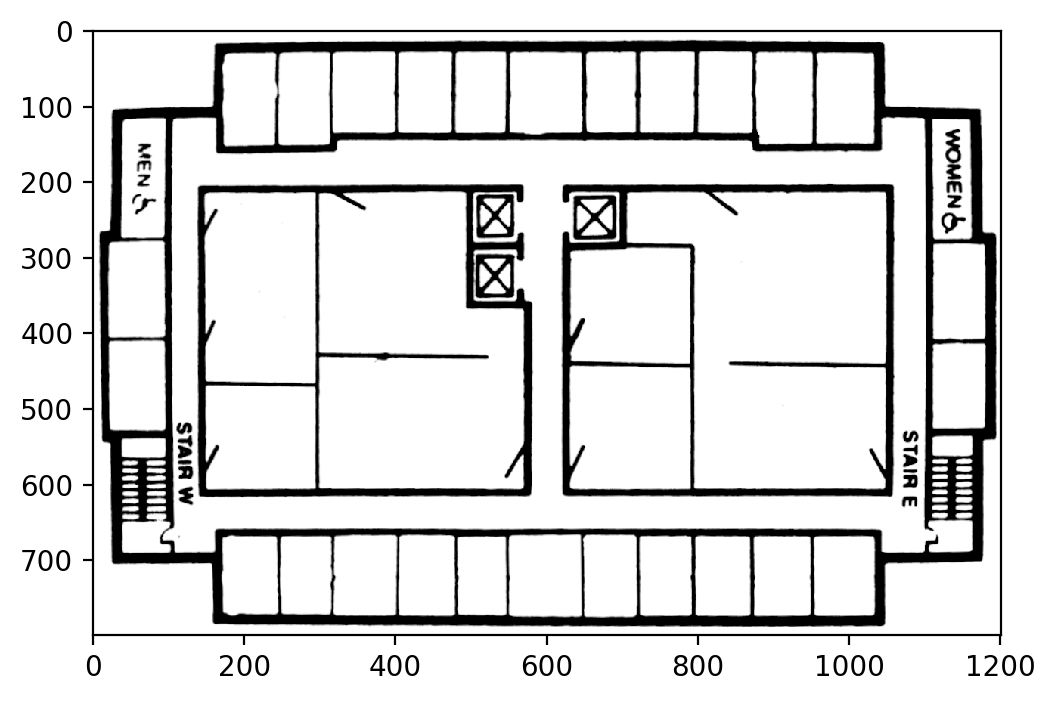

In [2]:
# Load the floor plan image. Use the straightened version with transparent background
floorplan = io.imread('floorplan_transparent.png')
plt.imshow(floorplan)

shape = floorplan.shape
print('Floorplan dimensions: width=%d height=%d' % (shape[1], shape[0]))

I looked up the building on OpenStreetMap and made the following screenshot of building detail.

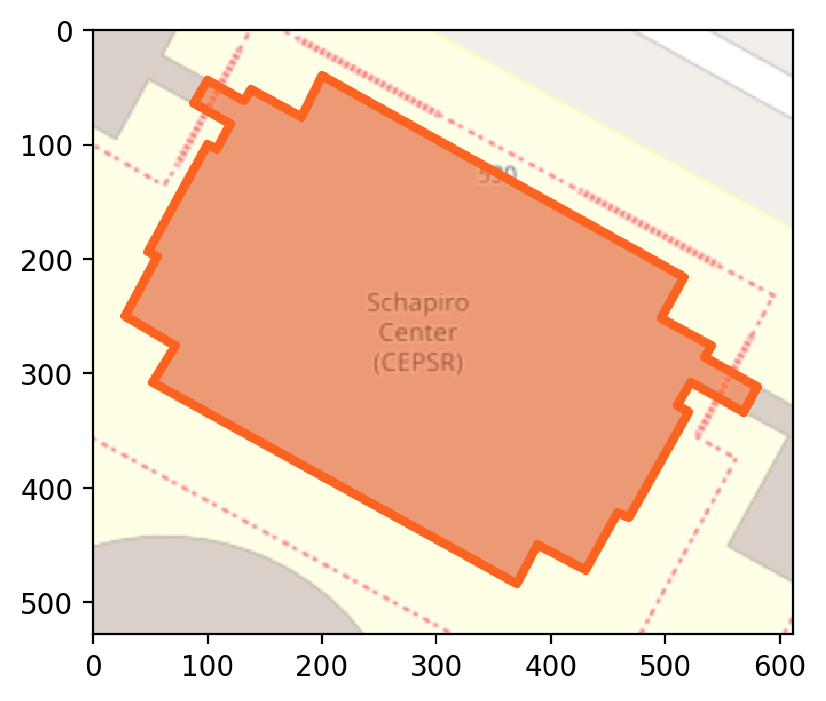

In [3]:
mapview = io.imread('cepsr_detail.png')

plt.imshow(mapview)

Next, I used a bitmap editor to find out the x,y coordinates of all building corners in both images (floorplan and map screenshot). There are 10 corners in total. The variable ref contains a reference point for each corner.

In [4]:
ref = [
    RefPoint(Point( 161, 697), Point( 69, 275)),
    RefPoint(Point( 166, 778), Point( 53, 306)),
    RefPoint(Point(1039, 779), Point(369, 482)),
    RefPoint(Point(1041, 697), Point(389, 450)),
    RefPoint(Point(1169, 694), Point(430, 471)),
    RefPoint(Point(1170, 534), Point(458, 421)),
    RefPoint(Point(1187, 532), Point(468, 424)),
    RefPoint(Point(1187, 274), Point(519, 334)),
    RefPoint(Point(1169, 273), Point(509, 328)),
    RefPoint(Point(1167, 109), Point(539, 275)),
    RefPoint(Point(1040, 106), Point(497, 250)),
    RefPoint(Point(1039,  21), Point(515, 216)),
    RefPoint(Point( 167,  22), Point(200,  40)),
    RefPoint(Point( 165, 106), Point(182,  74)),
    RefPoint(Point(  31, 109), Point(137,  52)),
    RefPoint(Point(  31, 270), Point(107, 103)),
    RefPoint(Point(  14, 271), Point(100,  99)),
    RefPoint(Point(  16, 536), Point(49,  192)),
    RefPoint(Point(  30, 537), Point(54,  198)),
    RefPoint(Point(  31, 697), Point(29,  249))
]

To double-check that the x,y coordinates are correct, let's draw the points over the images. Reference point with index 0 is highlighed in blue. Reference points are counted counter clockwise.

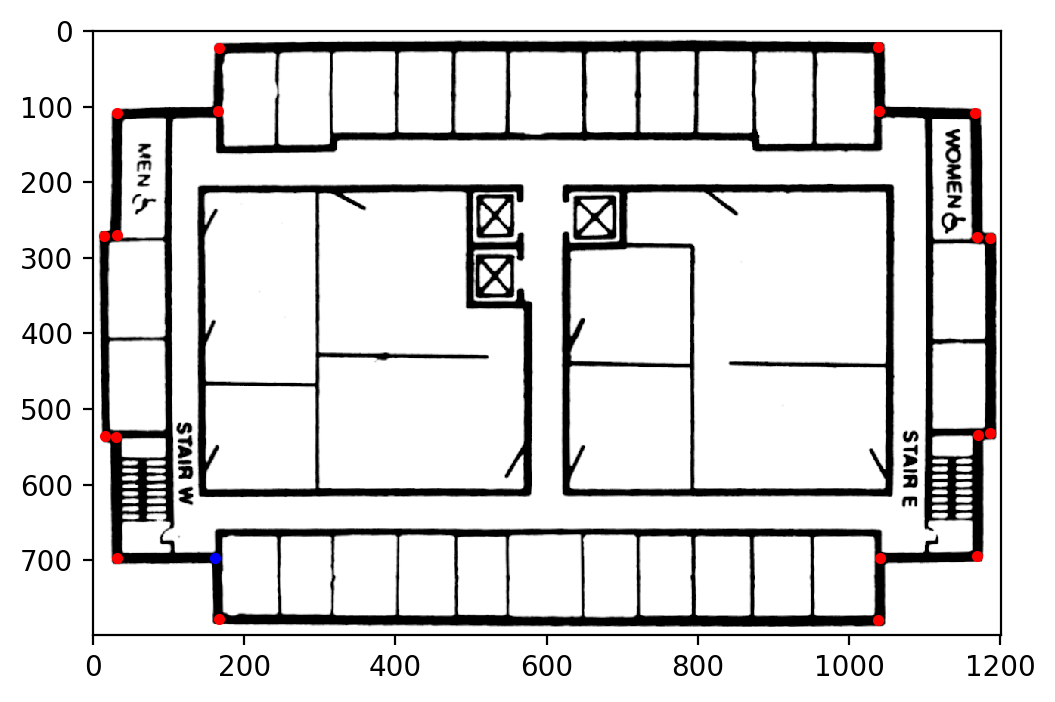

In [5]:
plt.imshow(floorplan)
i = 0
for r in ref:
    plt.plot(*r.old, color="blue" if i == 0 else "red", marker='o', markersize=3)
    i = i + 1

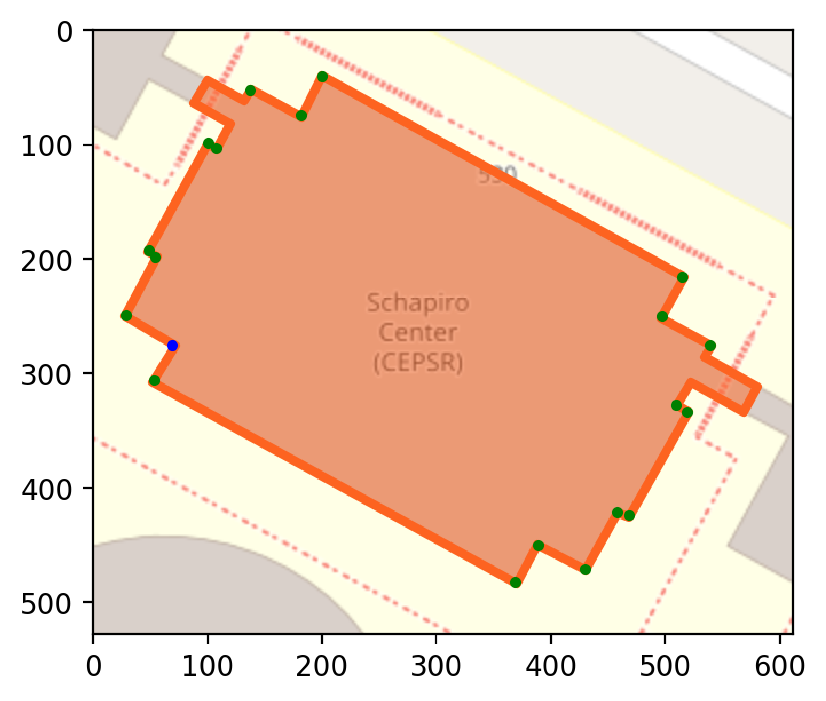

In [6]:
plt.imshow(mapview)
i = 0
for r in ref:
    plt.plot(*r.new, color="blue" if i == 0 else "green", marker='o', markersize=3)
    i = i + 1

First, let's try to use two reference points to transform the floorplan image into the reference frame of the mapview. We plot the transformed floorplan over the mapview to see the result. This method very closely resembles the transformation that Alex's Java application is doing. Thus, the result that we get here will be very similar to what the Java application would provide.

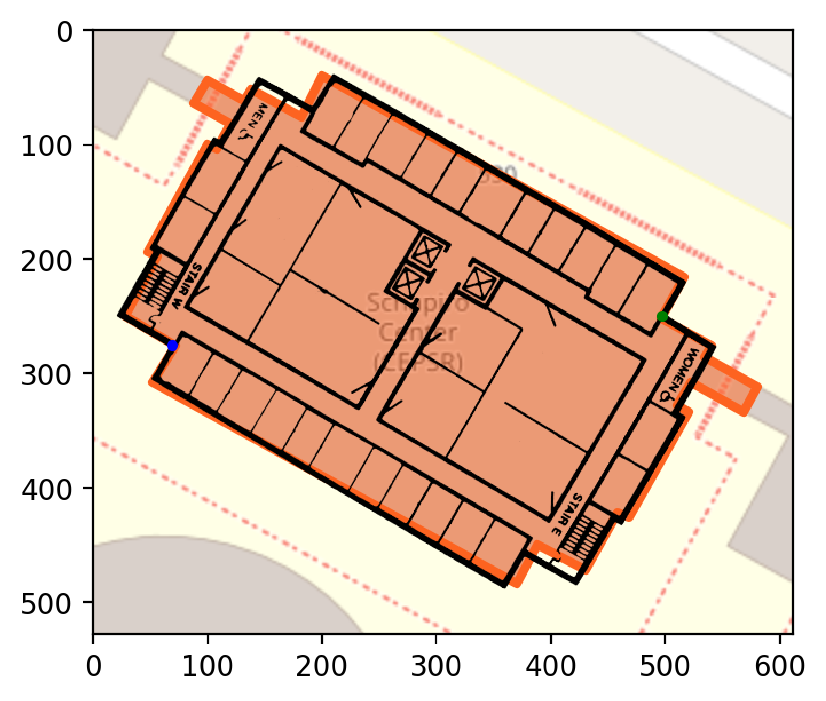

In [7]:
ref_a = ref[0]  # Bottom-left inner building corner
ref_b = ref[10] # Upper-right inner building corner

old = polyline2array([v.old for v in [ref_a, ref_b]])
new = polyline2array([v.new for v in [ref_a, ref_b]])

# Given the two reference points A and B, estimate the transformation that is
# needed to translate the floorplan's coordinates into mapview coordinates.
# Function estimate_transform estimates the scale, rotation, and translation
# factors and returns those in form of a transform matrix. 
#
# With only two reference points we cannot really estimate shear or skew and
# must use the simpler 'similarity' transform method instead of the more
# general 'affinnity' transform method.
#
# Internally, the function estimate_transform uses the least squares method
# to estimate the rotation, scale, and translation parameters using the given
# reference points.
#
# With only two reference points, the method used here is very similar to what
# the Java application is using. Thus, the image we get will be very similar 
# to what the Java application would produce in terms of fit.

transform = estimate_transform('similarity', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

# Draw both images over each other

plt.imshow(mapview)
plt.imshow(image)

# Highlight the two reference points

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)

The fit is okay, but far from perfect. There is noticeable mis-alignment in the upper-left and bottom-right corners. This is most likely due to the fact that the floorplan has a slightly different aspect ration than the building in OpenStreetMap. Note that the bottom-left and upper-right inner building corners are aligned perfectly. These were our reference points. In the above image the reference points are highlighted in blue and green. This basic method would be good enough if the floorplan we work with is high-quality, with correct dimensions and aspect ratio.

Let's retry this with different reference points. Let's use bottom-left and upper-right outer building corners this time. These are a bit further away from each other.

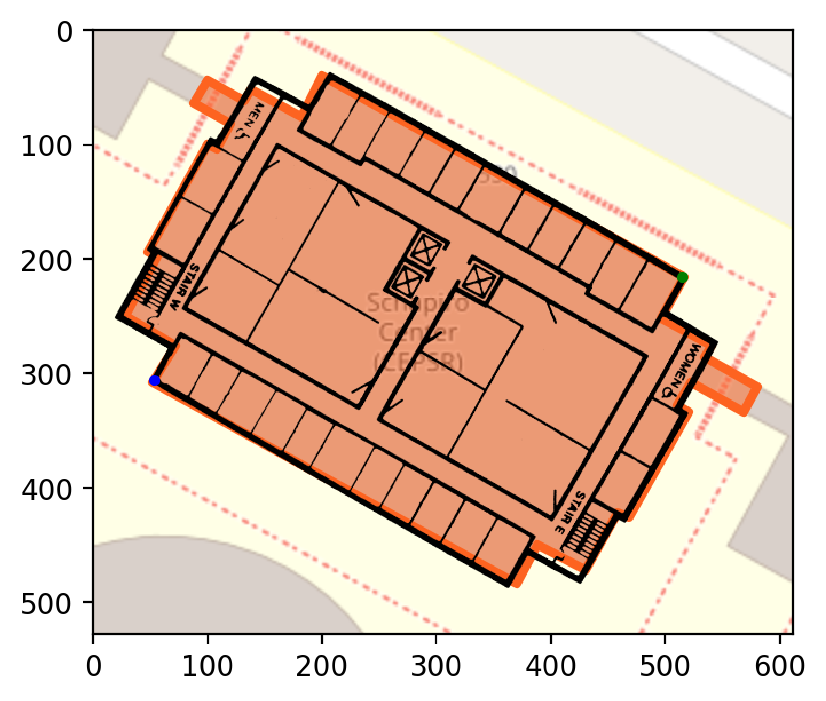

In [8]:
ref_a = ref[1]  # Bottom-left outer building corner
ref_b = ref[11] # Upper-right outer building corner

old = polyline2array([v.old for v in [ref_a, ref_b]])
new = polyline2array([v.new for v in [ref_a, ref_b]])

transform = estimate_transform('similarity', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)

The fit is noticeably better here. The upper-left and bottom-right corners are still mis-aligned, but less than in the previous image. It seems that the choice of reference points matters. I suspect that the eastern and western sections of the building wall do not really match in the floorplan and in the map. When their points are selected as reference points, we get worse fit. In this picture, we selected two reference points that do not lie on the eastern or western wall sections and we get a better fit.

Let's see whether adding a third reference point would help.

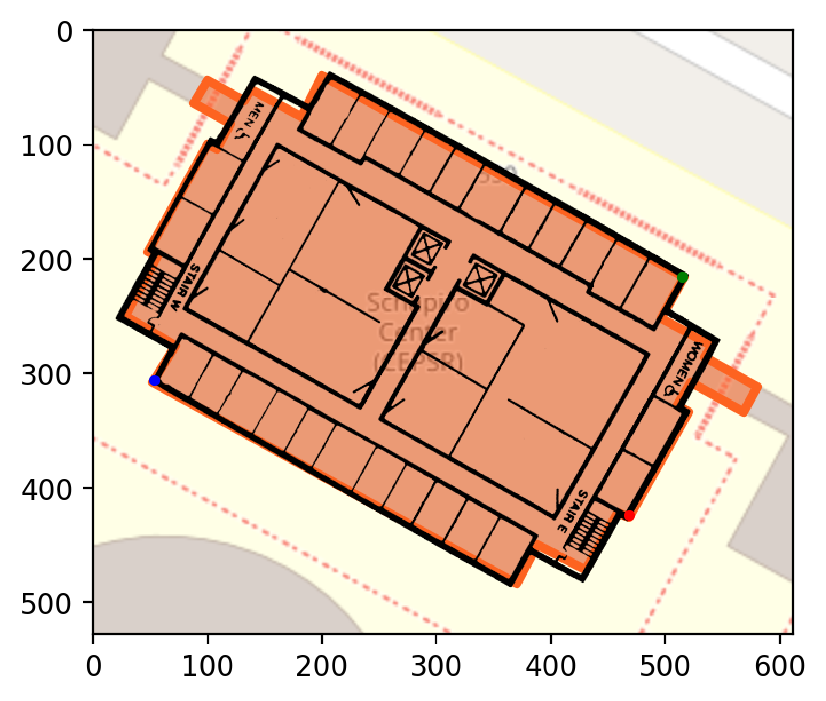

In [9]:
ref_a = ref[1]  # Bottom-left outer building corner
ref_b = ref[11] # Upper-right outer building corner
ref_c = ref[6]

old = polyline2array([v.old for v in [ref_a, ref_b, ref_c]])
new = polyline2array([v.new for v in [ref_a, ref_b, ref_c]])

transform = estimate_transform('similarity', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)
plt.plot(*ref_c.new, color="red", marker='o', markersize=3)

Slightly better than the previous image. So, adding a third reference point also helps, even if we restrict our transformation operations to scaling, rotation, and translation (.e., no shear or similar operations).

Let's try 4 reference points.

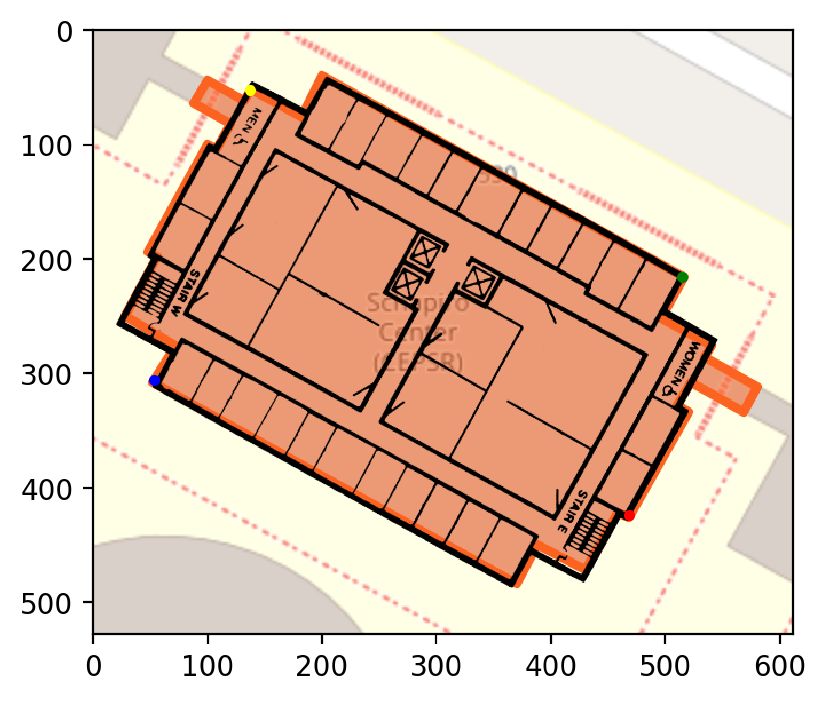

In [10]:
ref_a = ref[1]  # Bottom-left outer building corner
ref_b = ref[11] # Upper-right outer building corner
ref_c = ref[6]
ref_d = ref[14]

old = polyline2array([v.old for v in [ref_a, ref_b, ref_c, ref_d]])
new = polyline2array([v.new for v in [ref_a, ref_b, ref_c, ref_d]])

transform = estimate_transform('similarity', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)
plt.plot(*ref_c.new, color="red", marker='o', markersize=3)
plt.plot(*ref_d.new, color="yellow", marker='o', markersize=3)

The fit slowly improves, but the improvement from 3 to 4 reference points is hardly noticeable when using similarity transform.

Instead of adding more reference points to the similiarity transform, let's try full affine transform with the same 3 reference points.

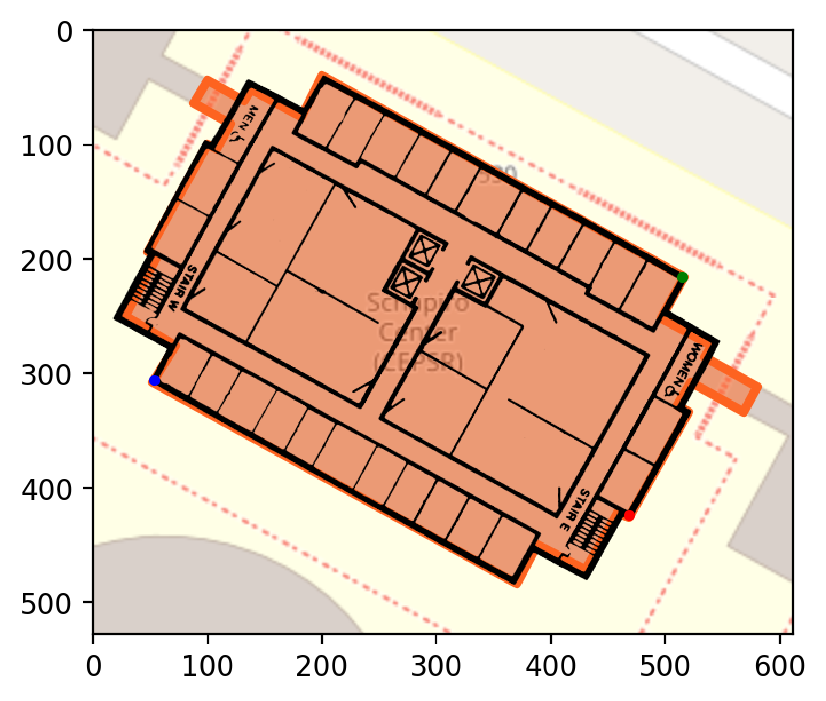

In [11]:
ref_a = ref[1]  # Bottom-left outer building corner
ref_b = ref[11] # Upper-right outer building corner
ref_c = ref[6]

old = polyline2array([v.old for v in [ref_a, ref_b, ref_c]])
new = polyline2array([v.new for v in [ref_a, ref_b, ref_c]])

transform = estimate_transform('affine', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

plt.plot(*ref_a.new, color="blue", marker='o', markersize=3)
plt.plot(*ref_b.new, color="green", marker='o', markersize=3)
plt.plot(*ref_c.new, color="red", marker='o', markersize=3)

As you can see above, switching to affine transformation made a big difference. With just 3 reference point, we can get much better fit. That's due to the additional transformation affine transformation can perform on the floorplan to correct the problematic aspect ration and the dimensions of the east-west walls. Some mis-alignment is still noticeable, but overall the fit looks very good. All important parts within the building appear to be matched correctly.

For completeness, here is an affine transformation using all 10 reference points. This is the best fit we can hope to obtain if we force the user to align all 10 building corners.

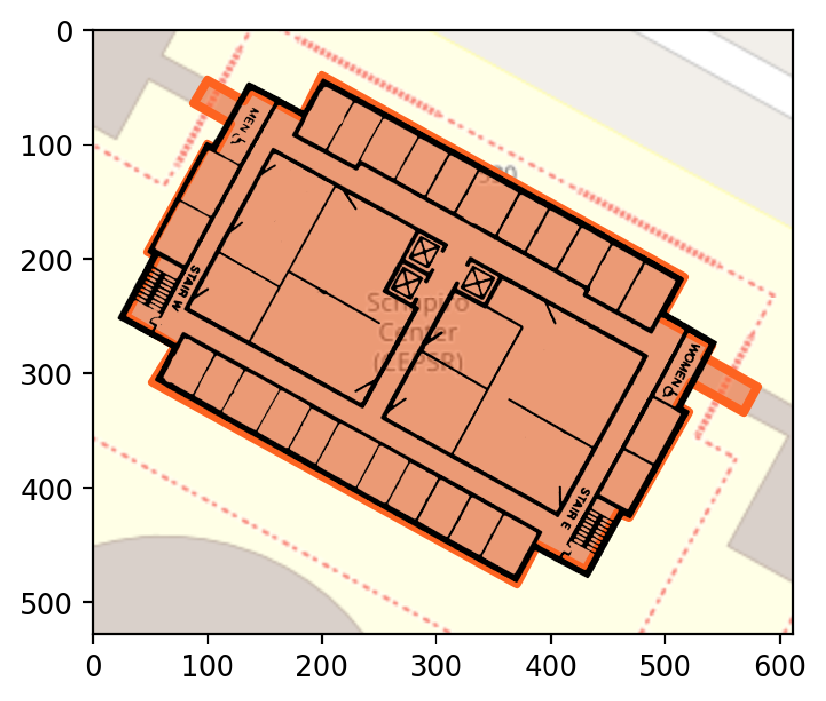

In [12]:
old = polyline2array([v.old for v in ref])
new = polyline2array([v.new for v in ref])

transform = estimate_transform('affine', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

This is pretty perfect. The only downside is that the user would need to align 10 reference points in the Java editor instead of just 2. If we can obtain the building model from OpenStreetMap automatically and provide some simple UI for the user to do it, it might be workable.

Let's show that this kind of transformation is usable with polygons, too. Here are three polygons for Henning's office, the IRT lab, and Costa Commons.

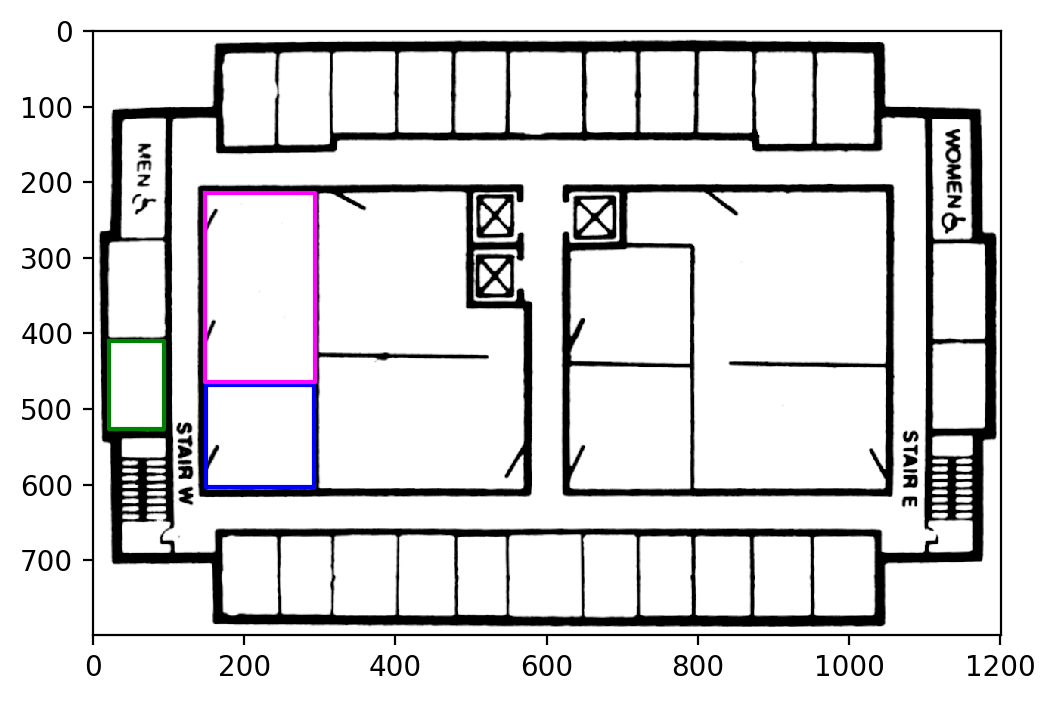

In [13]:
# Room 7LW2 a.k.a. IRT lab
irt = [Point(149, 469), Point(292, 469), Point(292, 603), Point(149, 603)]

# Room 750 a.k.a. Costa Commons
costa = [Point(148, 214), Point(293, 214), Point(293, 464), Point(148, 464)]

# Room 720 a.k.a. Henning's office
hgs = [Point(21, 410), Point(94, 410), Point(94, 526), Point(21, 526)]

# Reference point A, one of the corners of CEPSR for which we can obtain longitude,latitude from OpenStreetMap
ref_a = RefPoint(Point(161,  697), Point(69, 275))

# Reference point A, a corner of CEPSR on the other side of the building
ref_b = RefPoint(Point(1040, 106), Point(497, 250))
          
plt.plot(*plot(polygon(irt)), color="blue")
plt.plot(*plot(polygon(costa)), color="magenta")
plt.plot(*plot(polygon(hgs)), color="green")

plt.imshow(floorplan)

And the following picture shows the full transformation.

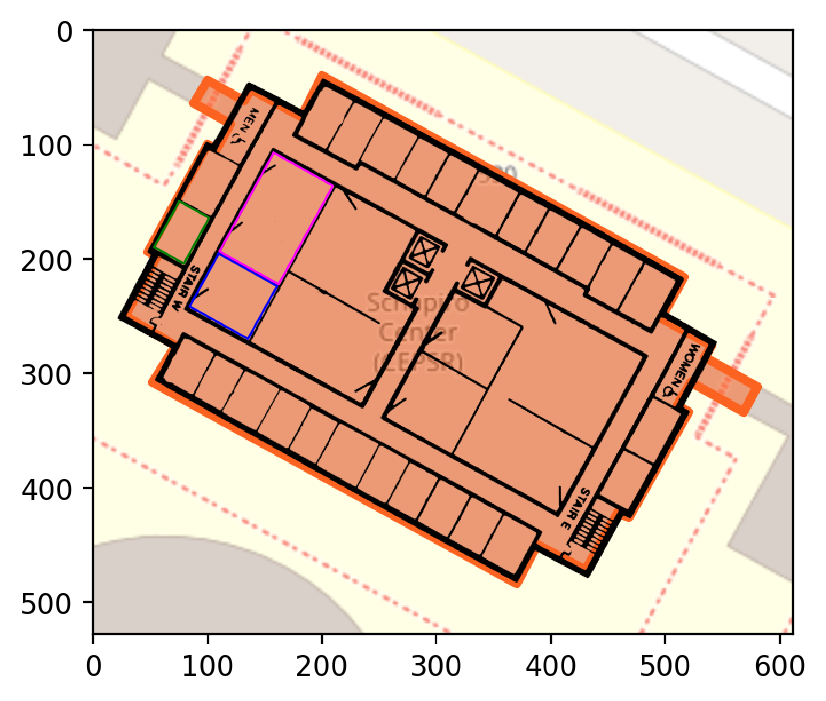

In [14]:
old = polyline2array([v.old for v in ref])
new = polyline2array([v.new for v in ref])

transform = estimate_transform('affine', old, new)

height, width, _ = mapview.shape
image = warp(floorplan, transform.inverse, output_shape=(height, width))

plt.imshow(mapview)
plt.imshow(image)

h, w, _ = floorplan.shape
coords = warp_coords(transform, shape=(h, w))

def transform(polyline):
    return [Point(coords[1][p.y][p.x], coords[0][p.y][p.x]) for p in polyline]

plt.plot(*plot(polygon(transform(irt))), linewidth=0.8, color="blue")
plt.plot(*plot(polygon(transform(costa))), linewidth=0.8, color="magenta")
plt.plot(*plot(polygon(transform(hgs))), linewidth=0.8, color="green")